In [412]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS (NGI)",
    "aviti_hq": "AVITI CB (HQ)",
    "xplus_sns": "NovaSeqX+ (S&S)",
}

sns.set_context("notebook", font_scale=1.1)

basedir = Path("../analysis/differential_coverage")

In [413]:
def load_data(tsv):
    data = pd.read_csv(tsv, sep='\t')

    data = data.melt(var_name='Stratification', value_name='Bases', id_vars='depth')
    data["Norm"] = data.groupby("Stratification")["Bases"].transform(lambda x: x / x.sum())
    data["NormMax"] = data.groupby("Stratification")["Bases"].transform(lambda x: x / x.max())
    data["CumulativeNorm"] = data.groupby("Stratification")["Norm"].transform(lambda x: x.cumsum())
    
    data = data[~data["Stratification"].str.startswith("chrY")]
    data = data[~data["Stratification"].str.startswith("chrX")]
    return data

def files():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]

    for run in runs:
        for cell in cells:
            file = basedir / "histogram" / f"{run}_{cell}.tsv"
            yield run, cell, file

data = []
for run, cell, file in files():
    d = load_data(file)
    d["run"] = run
    d["Cell line"] = cell
    d["Data source"] = d["run"].replace(run_names)
    data.append(d)

data = pd.concat(data).reset_index(drop=True)
#data = data[data["depth"] <= 20]

data.loc[data["Stratification"].str.startswith("SimpleRepeat"),"Stratification"] = data[data["Stratification"].str.startswith("SimpleRepeat")]["Stratification"].apply(lambda x: "_".join(x.split("_")[1:]))
data["Stratification"] = data["Stratification"].astype("category")
data.head()

,depth,Stratification,Bases,Norm,NormMax,CumulativeNorm,run,Cell line,Data source
0,0,notinrefseq_cds,168909309.0,0.058231,0.777779,0.058231,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
1,1,notinrefseq_cds,26297009.0,0.009066,0.121090,0.067297,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
2,2,notinrefseq_cds,51185753.0,0.017646,0.235696,0.084943,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
3,3,notinrefseq_cds,88641453.0,0.030559,0.408169,0.115502,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
4,4,notinrefseq_cds,130135797.0,0.044864,0.599238,0.160367,aviti_ngi,KMS12BM,AVITI CB FS (NGI)


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_51748/1774134327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False)["Bases"].sum()


['diTR_ge150_slop5', 'homopolymer_ge21_GC_slop5', 'quadTR_ge150_slop5', 'triTR_ge150_slop5']


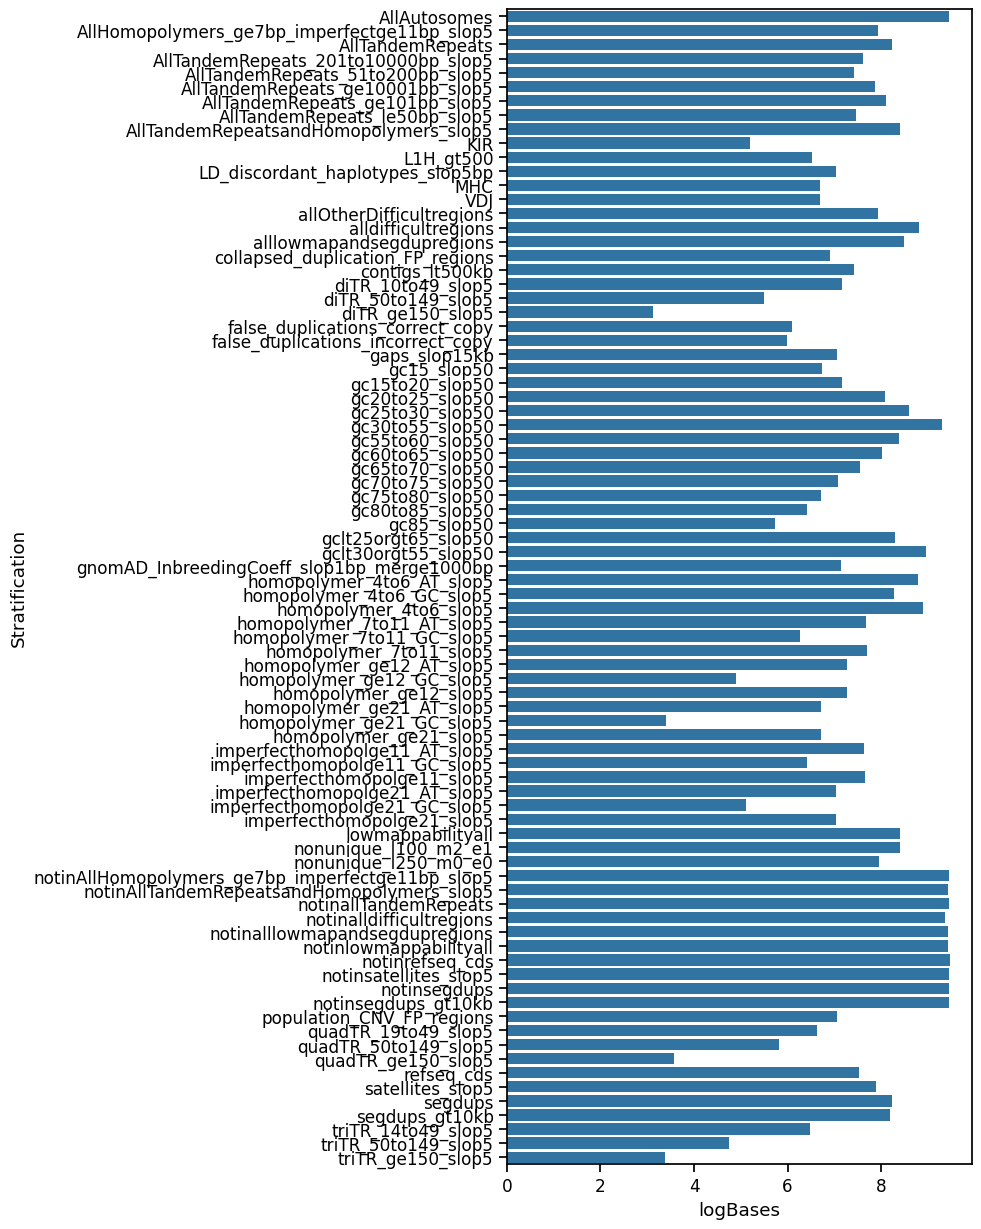

In [414]:
d = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False)["Bases"].sum()
d["logBases"] = d["Bases"].apply(np.log10)
print(d[d["Bases"] < 10_000]["Stratification"].unique().tolist())
d = d.sort_values(by="Bases")
#g = sns.catplot(d, kind="bar", y="Stratification", x="logBases", col="Cell line", aspect=0.3, height=12)
fig, ax = plt.subplots(figsize=(6,15))
ax = sns.barplot(d, y="Stratification", x="logBases", ax=ax)

## Autosomal chromosome coverage

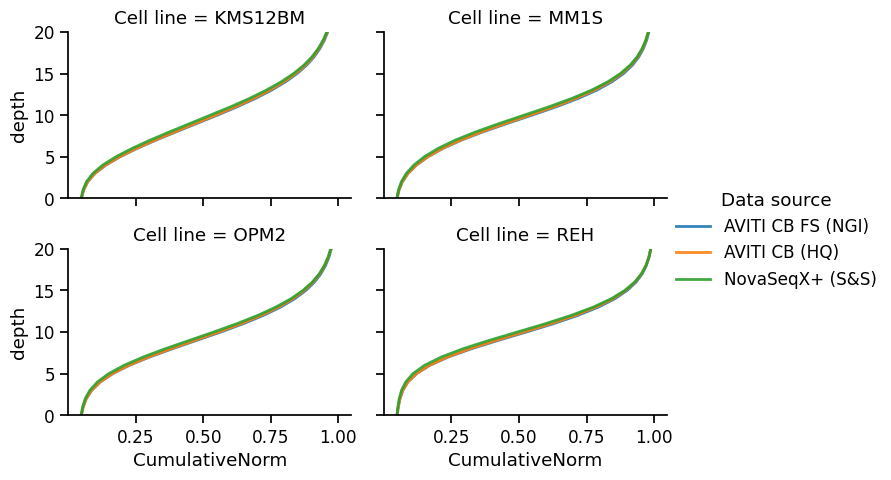

In [415]:
d = data.query("Stratification == 'AllAutosomes'")
g = sns.relplot(kind="line", data=d, y="depth", x="CumulativeNorm", 
                col="Cell line", lw=2, hue="Data source", height=2.5, aspect=1.5,
                col_wrap=2, alpha=0.9, )
g.set(ylim=(0,20))
#g.set_titles(col_template="{col_name}")

Coverage is even across Data sources

## Differential covergage
### Top stratifications by inter-cell line variability across datasets

In [416]:
import scipy.interpolate

def coverage_stats(x):
    zero_cov = float(x[x["depth"] == 0]["CumulativeNorm"])
    mean = (x["depth"] * x["Bases"]).sum() / x["Bases"].sum()

    # Median
    y_interp = scipy.interpolate.interp1d(x["CumulativeNorm"], x["depth"])
    if x["CumulativeNorm"].min() > 0.5:
        median = 0
    else:
        median = y_interp(0.5)    

    # AUC
    auc = np.trapezoid(x=x["CumulativeNorm"], y=x["depth"])
    
    return pd.Series(dict(
        mean=mean,
        median=median,
        auc=auc,
        zerocov=zero_cov
    ))

d = data.copy().reset_index()

# Ignore startifications with low coverage as this increases random variations
ds = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False)["Bases"].sum()
strats_removed = ds[ds["Bases"] < 10_000]["Stratification"].unique().tolist()
d = d[~d["Stratification"].isin(strats_removed)]


stats = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(coverage_stats)
stats = stats[~stats["mean"].isna()]

stats_list = ["mean", "median", "auc", "zerocov"]
stats_to_strats = {}
for stat in stats_list:
    var = stats.groupby(["Stratification", "Cell line"], as_index=False, observed=False)[stat].var()
    strats = var.sort_values(by=stat, ascending=False)["Stratification"].unique().tolist()[:50]
    stats_to_strats[stat] = strats
    print(stat, strats)

print()
from itertools import combinations
for s1,s2 in combinations(stats_list, 2):
    inters = set(stats_to_strats[s1]) & set(stats_to_strats[s1])
    print(s1, s2)
    print(*list(enumerate(zip(stats_to_strats[s1],stats_to_strats[s2]), start=1)), sep="\n")
    print("intersect", len(inters))#, inters)
    print()


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_51748/977661915.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_cov = float(x[x["depth"] == 0]["CumulativeNorm"])


mean ['gc85_slop50', 'gc80to85_slop50', 'gc75to80_slop50', 'quadTR_50to149_slop5', 'imperfecthomopolge21_GC_slop5', 'homopolymer_ge12_GC_slop5', 'imperfecthomopolge11_GC_slop5', 'gc70to75_slop50', 'triTR_50to149_slop5', 'homopolymer_ge21_AT_slop5', 'homopolymer_ge21_slop5', 'gc65to70_slop50', 'diTR_50to149_slop5', 'homopolymer_7to11_GC_slop5', 'quadTR_19to49_slop5', 'imperfecthomopolge21_AT_slop5', 'imperfecthomopolge21_slop5', 'gc15to20_slop50', 'homopolymer_ge12_AT_slop5', 'homopolymer_ge12_slop5', 'gc60to65_slop50', 'gc15_slop50', 'gc20to25_slop50', 'false_duplications_correct_copy', 'diTR_10to49_slop5', 'AllTandemRepeats_51to200bp_slop5', 'gc25to30_slop50', 'AllTandemRepeats_201to10000bp_slop5', 'KIR', 'triTR_14to49_slop5', 'imperfecthomopolge11_slop5', 'LD_discordant_haplotypes_slop5bp', 'imperfecthomopolge11_AT_slop5', 'homopolymer_7to11_slop5', 'refseq_cds', 'homopolymer_7to11_AT_slop5', 'AllHomopolymers_ge7bp_imperfectge11bp_slop5', 'homopolymer_4to6_AT_slop5', 'gc55to60_slop50

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_51748/977661915.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(coverage_stats)


<Axes: xlabel='Stratification', ylabel='Data source-Cell line'>

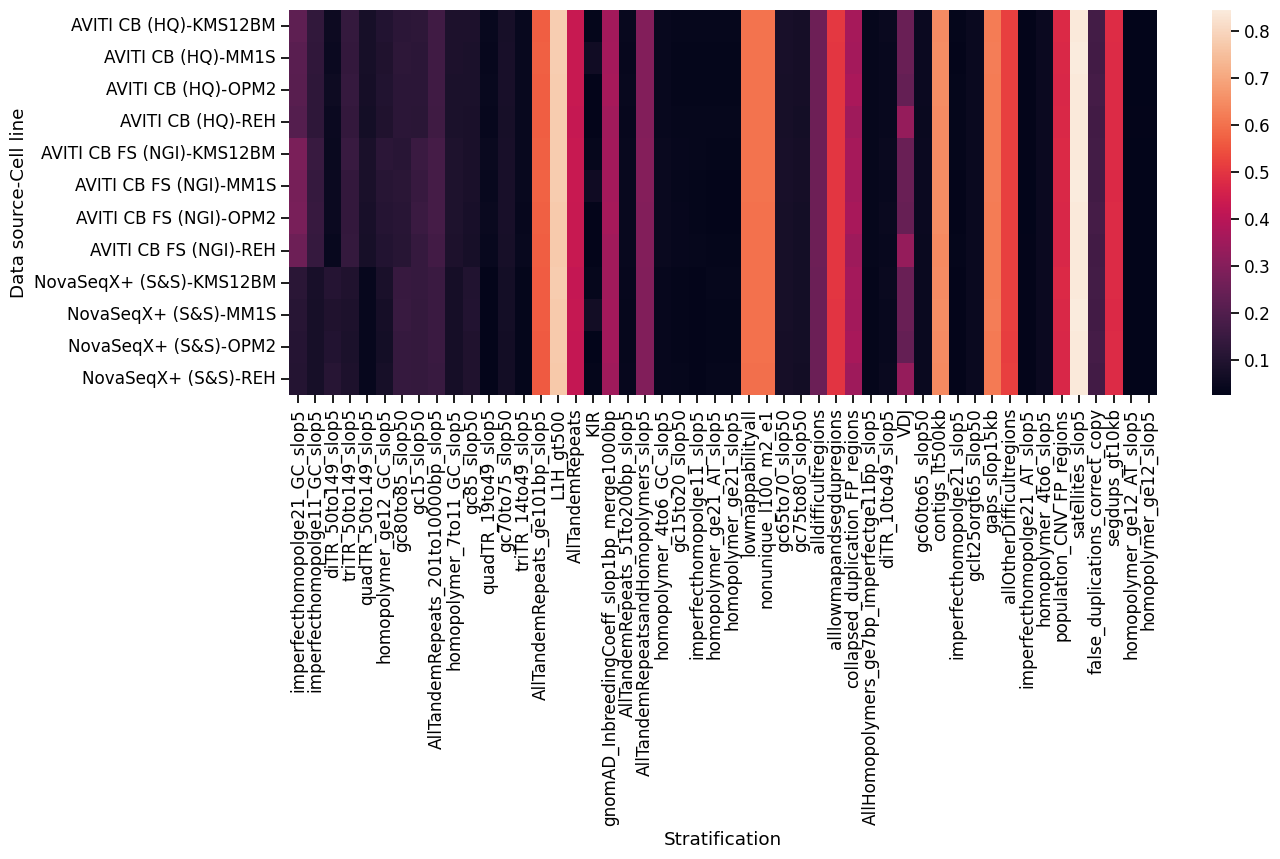

In [417]:
d = stats.pivot(index=["Data source", "Cell line"], columns="Stratification", values="zerocov")
d = d[strats]
fig, ax = plt.subplots(figsize=(14,5))
sns.heatmap(d, ax=ax)

<Axes: xlabel='Stratification', ylabel='Data source-Cell line'>

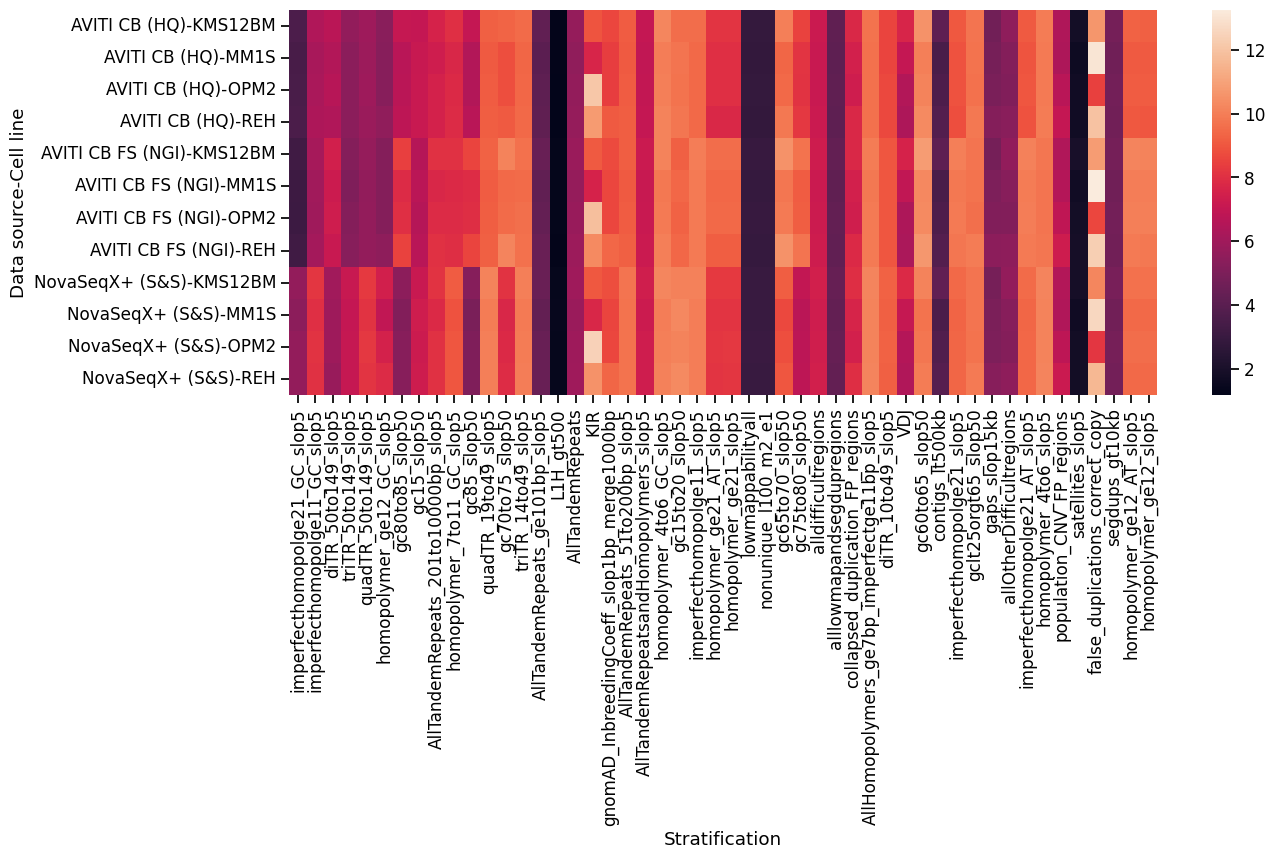

In [418]:
d = stats.pivot(index=["Data source", "Cell line"], columns="Stratification", values="mean")
d = d[strats]
fig, ax = plt.subplots(figsize=(14,5))
sns.heatmap(d, ax=ax)

The top10 are the same for different summary metrics, using mean.

### Plot Top10 variable stratifications in relation to AllAutosomal (baseline)

In [419]:
stats_to_strats["mean"][:15]

['gc85_slop50',
 'gc80to85_slop50',
 'gc75to80_slop50',
 'quadTR_50to149_slop5',
 'imperfecthomopolge21_GC_slop5',
 'homopolymer_ge12_GC_slop5',
 'imperfecthomopolge11_GC_slop5',
 'gc70to75_slop50',
 'triTR_50to149_slop5',
 'homopolymer_ge21_AT_slop5',
 'homopolymer_ge21_slop5',
 'gc65to70_slop50',
 'diTR_50to149_slop5',
 'homopolymer_7to11_GC_slop5',
 'quadTR_19to49_slop5']

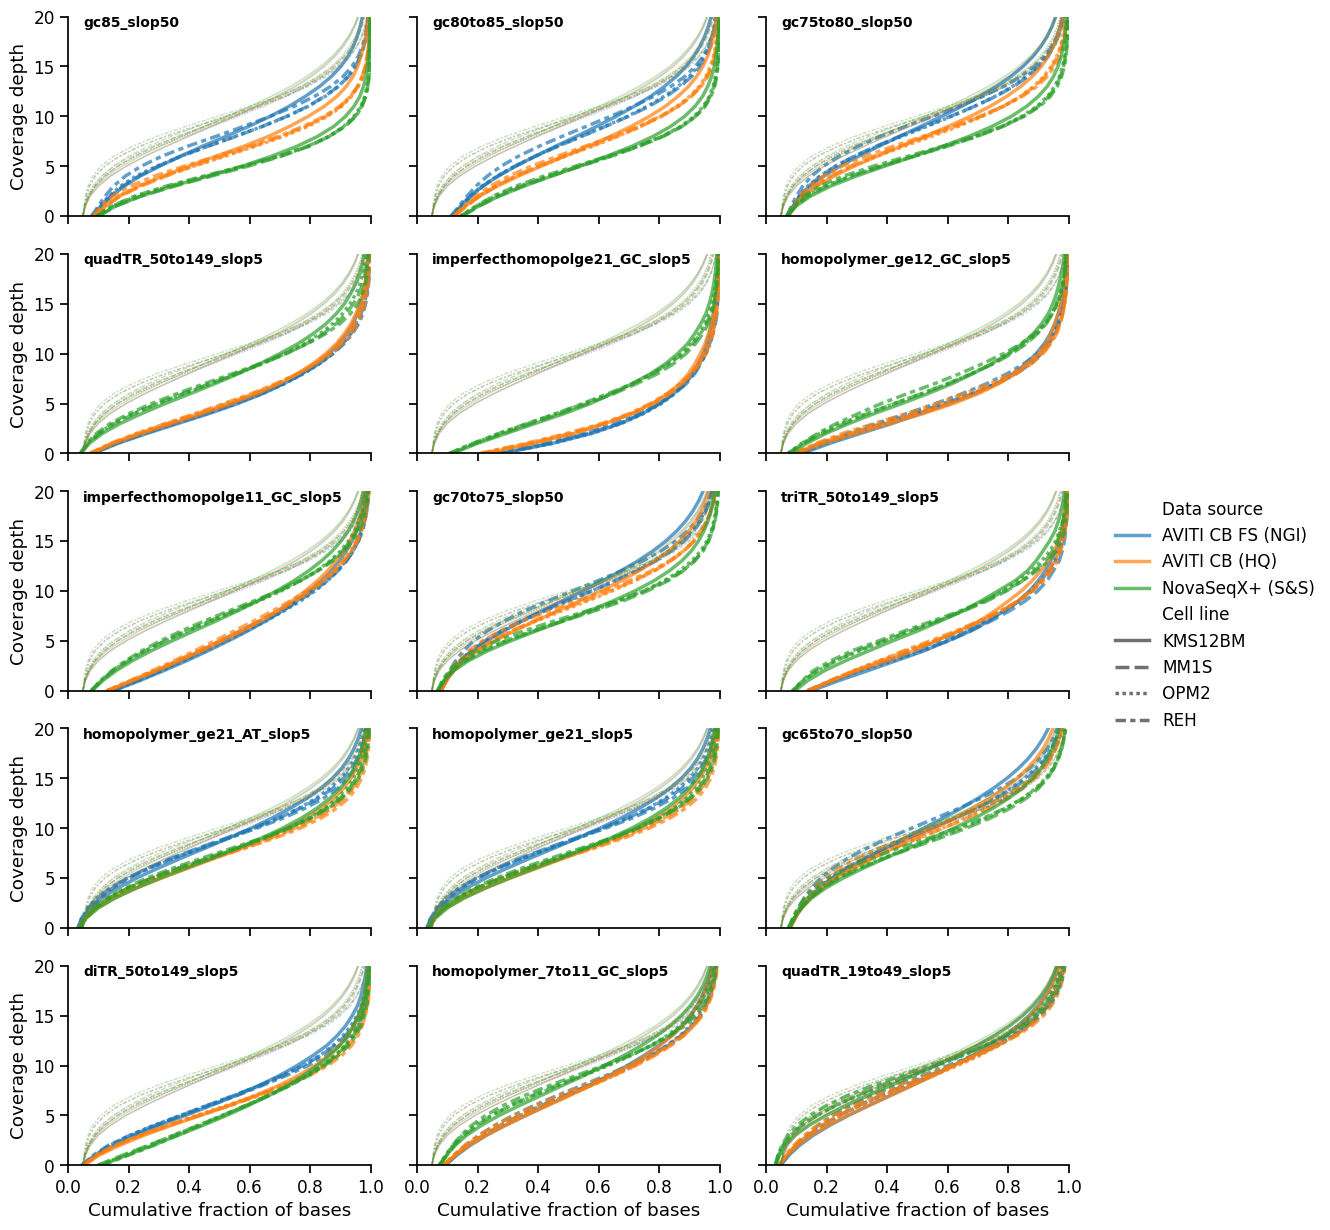

In [420]:
strats = stats_to_strats["mean"][:15]
d = data[data["Stratification"].isin(strats)]
g = sns.relplot(kind="line", data=d, y="depth", x="CumulativeNorm", hue_order=run_names.values(),
                col="Stratification", lw=2.5, hue="Data source", style="Cell line", height=2.5, aspect=1.5,
                col_wrap=3, alpha=0.7, facet_kws=dict(sharey=True, sharex=True), col_order=strats)

g.set(ylim=(0,20), xlim=(0,1), xlabel="Cumulative fraction of bases", ylabel="Coverage depth")
#g.set_titles(col_template="{col_name}")
for s, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(.05, .95, s, transform=ax.transAxes, fontweight="bold", size=10)

    sns.lineplot(data[data["Stratification"] == "AllAutosomes"], y="depth", x="CumulativeNorm", estimator=None, 
                 lw=1, hue="Data source", style="Cell line", ax=ax, alpha=0.3, legend=False)
g.set_titles(col_template="")
g.tight_layout()

## Old stuff

Text(0.1, 0.9, 'y = 0.98x + 1.23\nR² = 0.95')

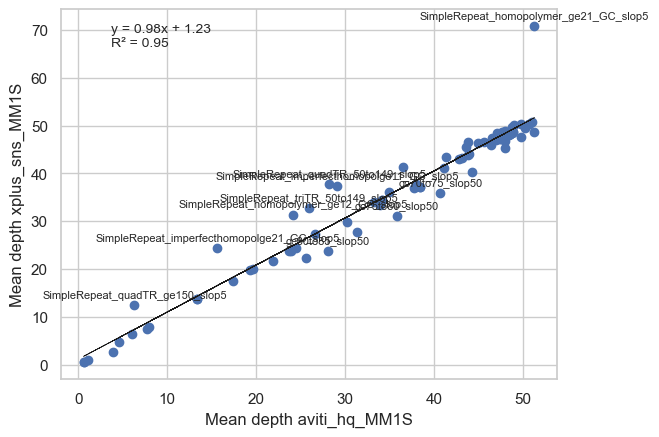

In [163]:
da = mean_depth(data)
da["MeanDepthRel"] = da["MeanDepth"] / da.loc["AllAutosomes"]["MeanDepth"]
dx = mean_depth(datax)
dx["MeanDepthRel"] = dx["MeanDepth"] / dx.loc["AllAutosomes"]["MeanDepth"]

fig, ax = plt.subplots()
ax.scatter(da["MeanDepth"], dx["MeanDepth"])

# Add regression line
z = np.polyfit(da["MeanDepth"], dx["MeanDepth"], 1)
p = np.poly1d(z)
plt.plot(da["MeanDepth"],p(da["MeanDepth"]),"k--", linewidth=0.5)

# Annotation for the points with the highest difference relative to the regression line
stratifications = []
for i, row in da.iterrows():
    if abs(dx.loc[i]["MeanDepth"] - p(row["MeanDepth"])) > 5:
        stratifications.append(i)
        # Annotate above the point
        ax.annotate(i, (row["MeanDepth"], dx.loc[i]["MeanDepth"]), fontsize=8, xytext=(0, 5), textcoords='offset points', ha='center')

ax.set_xlabel("Mean depth aviti_hq_MM1S")
ax.set_ylabel("Mean depth xplus_sns_MM1S")

# Add text for the regression line
r2 = np.corrcoef(da["MeanDepth"], dx["MeanDepth"])[0, 1] ** 2
plt.text(0.1, 0.9, f"y = {z[0]:.2f}x + {z[1]:.2f}\nR² = {r2:.2f}", transform=ax.transAxes, fontsize=10)